# Kapitel 12 - Neuronale Netze mit Keras

In [2]:
#check if gpu is available
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

## 12.1. Kapitelübersicht <a class="anchor" id="12-1"/>

In diesem Kapitel implementieren wir Neuronale Netze mithilfe der Deep-Learning-Bibliothek <b>Keras</b>. Zusätzlich werden wir uns Evaluierungsmethoden und Methoden gegen das Overfitting anschauen. Zuletzt werden wir uns mit dem Wrapper <b>hyperas</b> beschäftigen, mit dem wir Hyperparameter bei Keras optimieren können.

<b>Abschnittsübersicht</b><br>

[12.1. Kapitelübersicht](#12-1)<br>
[12.2. Implementierung in Keras](#12-2)<br>
[12.3. Evaluierung eines Keras Modells](#12-3)<br>
[12.4. Methoden gegen das Overfitting](#12-4)<br>
[12.4.1. Das Neuronale Netz verkleinern](#12-4-1)<br>
[12.4.2. Regularisierung der Gewichtungen](#12-4-2)<br>
[12.4.3. Dropout](#12-4-3)<br>
[12.4.4. Early Stopping](#12-4-4)<br>
[12.4.5. Kombination aller Overfitting-Methoden](#12-4-5)<br>
[12.5. Hyperparameteroptimierung mit hyperas](#12-5)<br>
[12.6. Mögliche Fehler](#12-6)<br>

Am Ende dieses Kapitel werden wir folgende Themen behandelt und/oder vertieft haben:
- Implementierung eines Neuronalen Netz in Keras
- One-Hot-Encoding
- F1-score als Evaluierungsmaß für Keras
- Funktion zur Visualisierung von Trainingsergebnissen
- Methoden gegen Overfitting
    - Netzwerkverkleinerung
    - Regularisierung
    - Dropout
    - Early Stopping
- Kombination der Overfitting Methoden zum Training eines finalen Modells
- Einführung in hyperas für Hyperparameteroptimierung
- OOM-Problem und Lösungsvorschläge für hyperas

## Kapitel 12.2. Implementierung in Keras <a class="anchor" id="12-2"/>

<div class="alert alert-warning">
<b>Aufgabe:</b> Kapitel 3 - Einführung in Neuronale Netze<br>
    
Lesen Sie Kapitel 3 und implementieren Sie die Beispiele in einem Jupyter Notebook. Besonderer Fokus sollte auf Kapitel 3.5 gelegt werden. Kapitel 3.6 sollten Sie zwar lesen, Regression wird in dieser Tutorialreihe jedoch nicht weiter behandelt.<br><br>

<b>Hinweise</b>:
- Wenn eine NVIDIA Grafikkarte mit GPU vorhanden ist, sollten die Modelle am besten auf der GPU trainiert werden. <b>Achtung</b>: Der Installationsprozess kann teilweise sehr frustrierend sein. Achten Sie auf die richtigen Versionen der verschiedenen Module. Onlineguides sollten Ihnen dabei helfen. <b>Tipp</b>: Installieren Sie Cuda und tensorflow-gpu in einer eigenen Environment, da es oft Probleme mit Numpy- und anderen Modul-Versionen gibt.
- Sollte keine GPU vorhanden sein oder die Installation nicht funktionieren, empfehle ich, <a href="https://colab.research.google.com/notebooks/welcome.ipynb#recent=true"><b>Google Colab</b></a> zu nutzen. Google Colab funktioniert ähnlich wie Jupyter Notebooks und bietet kostenlosen GPU-Speicher. Unter `File/Open Notebook` können Jupyter Notebooks hochgeladen werden. Unter `Runtime/Change runtime type` kann als Hardware accelerator die GPU ausgewählt werden. Am Anfang jedes der folgenden Tutorial-Notebooks stelle ich zwei Zeilen Code zur Verfügung, mit denen getestet werden kann, ob die GPU verfügbar ist. Dies sollte immer vor dem eigentlichen Training getestet werden.
- Chollet benutzt die <b>One-Hot-Codierung</b> nicht immer richtig. Verwenden Sie am besten immer `to_categorical` von `from keras.utils.np_utils import to_categorical` anstatt den Code, den Chollet selbst erstellt hat.<br><br>


<b>Weitere Aufgaben</b>:
- Führen Sie einige der Experimente aus den Kapiteln 3.4.6. und 3.5.8. aus.
</div>

#### Importe

In [4]:
from keras import models
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Korpus laden

In [5]:
corpus = pd.read_csv("tutorialdata/corpora/wikicorpus_v2.csv")

#### Vektorisierung der Daten

Die Trainings- und Testdatensätze teilen wir nicht wie sonst üblich 80/20, sondern 60/40. Der Grund dafür ist, dass wir im Anschluss einen Validierungdatensatz aus den Testdatensätzen erzeugen, indem wir die Testdatensätze halbieren. Am Ende haben wir die Aufteilung 60/20/20 (Trainingsdatensatz/Validierungsdatensatz/Testdatensatz). Zudem erstellen wir ein Dictionary mit dem Namen `vocab`, welches alle in unseren Texten vorkommenden Wörter mit ihrer Häufigkeit speichern. Dieses benötigen wir für unser Modell.

In [6]:
vectorizer = TfidfVectorizer()
vector = vectorizer.fit_transform(corpus["text"])
labels = LabelEncoder().fit_transform(corpus["category"])
vocab = vectorizer.vocabulary_




X_train, X_test, y_train, y_test = train_test_split(vector, 
                                                    labels, 
                                                    test_size=0.4, 
                                                    train_size=0.6,
                                                    random_state=42)
X_val = X_test[:1200]
X_test = X_test[1200:]

y_val = y_test[:1200]
y_test = y_test[1200:]

#### One-Hot-Encoding der Daten

<div class="alert alert-info">
<b>Exkurs:</b> One-Hot-Encoding <br>
    
Mithilfe von <b>One-Hot-Encoding</b> werden Features als binäre Vektoren repräsentiert. Ein Vektor eines Features besteht dabei nur aus Nullen, bis auf die Stelle des Features, die 1 ist.

<u>Beispiel</u>:

Wir haben den Text "Die Hauptstadt ist Berlin" vorliegen. Die Features, die wir aus diesem Text extrahieren, sind die einzelnen Wörter. Bei dem sogenannten <b>Integer Encoding</b> würden wir jedem Wort einen eindeutigen Integerwert zuordnen. Das könnten folgendermaßen aussehen:<br>
"Die": 1<br>
"Hauptstadt": 2<br>
"ist": 3<br>
"Berlin": 4<br><br>

Beim <b>One-Hot-Encoding</b> würde der Text folgendermaßen repräsentiert werden:<br>
"Die": [1, 0, 0, 0]<br>
"Hauptstadt": [0, 1, 0, 0]<br>
"ist": [0, 0, 1, 0]<br>
"Berlin": [0, 0, 0, 1]<br>

Die Länge der Vektoren wird durch die Anzahl der Features bestimmt.<br><br>

Zum Vergleich: Beim <b>Bag-of-Words-Modell</b> würde der Text folgendermaßen repräsentiert werden:<br>
"Die": 1<br>
"Hauptstadt": 1<br>
"ist": 1<br>
"Berlin": 1<br>
Da jedes Wort nur ein einziges Mal vorkommt, ist jeder Eintrag "1".
</div>

In [7]:
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)

#### Ein Neuronales Netz für Multiclass Klassifizierung

Unser Modell besteht aus einem Input-Layer, einem Hidden-Layer und einem Output-Layer. Wir haben hier ein 2-layer Netz vorliegen (der Input-Layer wird nicht mitgezählt). Als Aktivierungsfunktion benutzen wir die RELU-Funktion (siehe Kapitel 3.4.3). Als <i>hidden units</i> (deutsch: verdeckte Einheit, siehe Kapitel 3.4.3 in Chollets Buch) haben wir `64` gewählt.<br>

Im Input-Layer gibt es den Parameter `input_shape`. Dieser gibt an, welche Dimension die Daten haben. Hier können wir die Länge unseres Vokabulars angeben, d.h. die Anzahl der verschiedenen Wörter unseres Korpus. Im Output-Layer müssen wir die Dimension des Vektors angeben, die das Neuronale Netz für jede Eingabe ausgibt. Da unser Korpus 30 verschiedene Kategorien besitzt, muss hier `30` stehen. Um sicher zu gehen, dass die Dimension auch wirklich passt, geben wir `len(np.unique(labels))` an, also die Anzahl aller einzigarten Labelbezeichnungen. Als Optimizer haben wir <b>rmsprop</b> verwendet. Auf die Wahl der Optimizer werden wir im nächsten Kapitel noch eingehen. Als Loss Function wählen wir <b>categorical_crossentropy</b>, die Umsetzung der cross entropy für mehr als 2 Klassen. Als Metrik nehmen wir die Classification accuracy (`accuracy`). In Kapitel 5 hatten wir eigentlich den <b>F1-score</b> als Evaluationsmaß festgelegt. Keras bietet jedoch seit der <a href="https://github.com/keras-team/keras/wiki/Keras-2.0-release-notes">Version 2.0</a> keinen F1-score mehr an (der <a href="https://github.com/keras-team/keras/issues/5794">Grund</a>). Wir werden zunächst ebenfalls nur die Classification Accuracy nutzen und den F1-score erst nach dem Training des Modells verwenden.

In [23]:
model = models.Sequential()
# Input Layer
model.add(layers.Dense(64, activation="relu", input_shape=(len(vocab),)))
# Hidden Layer
model.add(layers.Dense(64, activation="relu"))
# Output Layer
model.add(layers.Dense(len(np.unique(labels)), activation="softmax"))


model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

Hier trainieren wir unser Modell für 10 Epochen mit einer `batch_size` von `64`. Wenn kein Fortschrittsbalken erwünscht ist, muss `verbose = 0` gesetzt werden. Das Modell speichern wir im `history`-Objekt, welches uns Auskunft über die verschiedensten beim Training vorgefallenen Ereignisse liefert.<br>
Bei der Ausführung auf einer CPU dauert das Training etwa drei Minuten, auf einer GPU nur wenige Sekunden.

In [24]:
history = model.fit(X_train,
                   y_train,
                   epochs=10,
                   batch_size=64,
                   validation_data=(X_test, y_test),
                   verbose=1)

Train on 3600 samples, validate on 1200 samples
Epoch 1/10
3600/3600 [==============================] - 19s 5ms/step - loss: 3.1747 - acc: 0.3892 - val_loss: 2.8297 - val_acc: 0.4875
Epoch 2/10
3600/3600 [==============================] - 18s 5ms/step - loss: 2.2051 - acc: 0.7417 - val_loss: 1.8900 - val_acc: 0.7425
Epoch 3/10
3600/3600 [==============================] - 18s 5ms/step - loss: 1.1091 - acc: 0.9711 - val_loss: 1.1182 - val_acc: 0.8917
Epoch 4/10
3600/3600 [==============================] - 18s 5ms/step - loss: 0.4364 - acc: 0.9939 - val_loss: 0.6855 - val_acc: 0.9200
Epoch 5/10
3600/3600 [==============================] - 19s 5ms/step - loss: 0.1481 - acc: 0.9986 - val_loss: 0.4823 - val_acc: 0.9208
Epoch 6/10
3600/3600 [==============================] - 18s 5ms/step - loss: 0.0474 - acc: 0.9997 - val_loss: 0.3644 - val_acc: 0.9300
Epoch 7/10
3600/3600 [==============================] - 18s 5ms/step - loss: 0.0147 - acc: 1.0000 - val_loss: 0.3141 - val_acc: 0.9342
Epoch 8

#### Visualisieren der Ergebnisse

Für die Visualisierung der Ergebnisse fassen wir die Visualisierungsmethode aus dem Buch in einer Funktion `plot_results` zusammen. Im weiteren Verlauf der Tutorialreihe werden wir diese Visualisierungen nutzen, um unsere Ergebnisse zu interpretieren.

In [9]:
def plot_results(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "ro", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

    plt.clf() #clears the figure

    acc = history.history["acc"]
    val_acc = history.history["val_acc"]

    plt.plot(epochs, acc, "b", label="Training acc")
    plt.plot(epochs, val_acc, "ro", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Acc")
    plt.legend()

    plt.show()

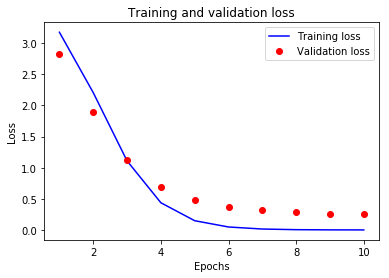

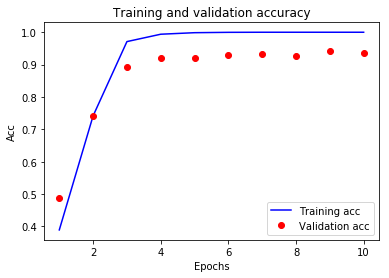

In [26]:
plot_results(history)

<u>Interpretation</u>:<br>
Die Loss Function verhält sich so, wie sie sollte, d.h. die Loss scores nehmen stetig ab und tendieren gegen Null. Die Trainings accuracy erreicht ab Epoche 3 beinahe 100%, ein Wert, der uns eigentlich zeigen sollte, dass unser Modell perfekt auf unsere Daten trainiert hat. Jedoch messen wir während des Trainingsvorgangs auch unsere Validation accuracy, die ab Epoche 4 etwa bei 92% liegt. Der Unterschied zwischen diesen beiden Werten ist sehr hoch. Unser Modell <b>overfittet</b>, d.h. es passt sich zu stark an die Trainingsdaten an. In einem späteren Abschnitt werden wir uns dem Overfitting widmen. 

## 12.3. Evaluierung eines Keras Modells <a class="anchor" id="12-3"/>

#### Berechnung des F1-scores

Wir können den F1-score nun berechnen, da unser Modell fertig trainiert ist. Anders als bei Scikit learn müssen wir hier jedoch zuvor `np.argmax` anwenden, welches den Index des größten Wertes jeder Zeile zurückgibt.

In [28]:
from sklearn.metrics import f1_score

y_pred = model.predict(X_test)
f1_keras = f1_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average="micro")
print("Der F1-score für die Klassifizierung mit Keras ist "
      + f"{str(np.around(f1_keras, decimals=3))}.")

Der F1-score für die Klassifizierung mit Keras ist 0.936.


#### Evaluation

Nun schauen wir uns die verschiedenen Scores an. Die Test accuracy und der F1-score haben beide etwa den Wert 0.936. Die Validation accuracy ist 0.863 und somit niedriger als die Training accuracy. Wie bereits erwähnt bedeutet dies, dass unser Modell <b>overfittet</b>.

In [30]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nResults:")
print(f"Train_acc: {np.around(np.mean(history.history['acc']), decimals=3)}")
print(f"Val_acc: {np.around(np.mean(history.history['val_acc']), decimals=3)}")
print(f"Test_acc: {np.around(test_acc, decimals=3)}") 
print(f"F1-score: {str(np.around(f1_keras, decimals=3))}")

1200/1200 [==============================] - 2s 2ms/step

Results:
Train_acc: 0.909
Val_acc: 0.863
Test_acc: 0.936
F1-score: 0.936


#### Cross validation mit Keras

Für eine Evaluierung von Keras Modellen könnten wir theoretisch auch Cross Validation nutzen. Während es im Bereich des Machine Learning ein Gold-Standard für die Evaluierung von Klassifikationsverfahren ist, wird es im Bereich des Deep Learning nur selten eingesetzt. Deep Learning Modelle sind meist komplexer als die meisten Machine Learning Klassifikationsverfahren und können selbst auf einer GPU mehrere Stunde dauern. Eine Cross Validation würde deshalb sehr viel Rechenzeit benötigen. Bei kleineren Modellen kann es ein gutes Performance-Maß sein, wir werden Cross Validation jedoch in diesem Tutorial nicht als Evaluierungsmethode wählen.

## 12.4. Methoden gegen das Overfitting <a class="anchor" id="12-4"/>

<div class="alert alert-warning">
<b>Aufgabe:</b> Kapitel 4 - Grundlagen des Machine Learning <br>
    
Lesen Sie das Kapitel 4.4 "Überanpassung und Unteranpassung".<br><br>

<b>Optional</b>:
- Kapitel 4.1: Kurze Beschreibung der Teilgebiete des Machine Learning. Einige Dinge wie die Unterscheidung von binary, Multiclass und Multilabel Klassifizierung sind schon bekannt.
- Kapitel 4.2: Bewertungsmethoden für Machine Learning Modelle hatten wir bereits ausführlich in Kapitel 5 besprochen, die Implementierung der Cross Validation könnte jedoch interessant sein.
- Kapitel 4.3: Hier geht es allgemeiner um das Feature Engineering.
- Kapitel 4.5: Ein sehr wichtiges Kapitel für die allgemeine Nutzung von Machine Learning und Deep Learning für Nicht-Textklassifikation.

</div>

### 12.4.1. Das Neuronale Netz verkleinern <a class="anchor" id="12-4-1"/>

Der erste Vorschlag von Chollet zur Vermeidung von Overfitting ist die <b>Verkleinerung von Neuronalen Netzen</b>. Dazu kann man entweder die Größe der einzelnen Layer verändern oder Layer entfernen. Da wir nur einen Hidden Layer haben, versuchen wir zunächst, die Größe der Layer zu verkleinern (`64` → `16`). 

In [237]:
model = models.Sequential()
model.add(layers.Dense(16, activation="relu", input_shape=(len(vocab),)))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(len(np.unique(labels)), activation="softmax"))


model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train,
                   y_train,
                   epochs=10,
                   batch_size=64,
                   validation_data=(X_test, y_test),
                   verbose=1)

Train on 3600 samples, validate on 1200 samples
Epoch 1/10
3600/3600 [==============================] - 11s 3ms/step - loss: 3.3715 - acc: 0.1700 - val_loss: 3.3211 - val_acc: 0.3375
Epoch 2/10
3600/3600 [==============================] - 11s 3ms/step - loss: 3.2172 - acc: 0.3603 - val_loss: 3.1468 - val_acc: 0.3367
Epoch 3/10
3600/3600 [==============================] - 11s 3ms/step - loss: 2.9430 - acc: 0.4633 - val_loss: 2.8976 - val_acc: 0.3742
Epoch 4/10
3600/3600 [==============================] - 11s 3ms/step - loss: 2.5780 - acc: 0.5869 - val_loss: 2.5762 - val_acc: 0.5158
Epoch 5/10
3600/3600 [==============================] - 10s 3ms/step - loss: 2.1496 - acc: 0.7353 - val_loss: 2.2258 - val_acc: 0.6275
Epoch 6/10
3600/3600 [==============================] - 11s 3ms/step - loss: 1.7015 - acc: 0.8503 - val_loss: 1.8654 - val_acc: 0.7783
Epoch 7/10
3600/3600 [==============================] - 11s 3ms/step - loss: 1.2682 - acc: 0.9525 - val_loss: 1.5280 - val_acc: 0.8583
Epoch 8

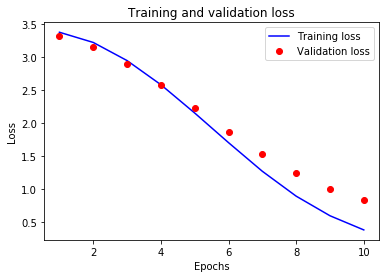

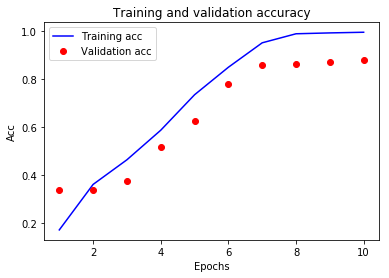

In [238]:
plot_results(history)

Da wir im weiteren Verlauf uns neben der Trainingskurve auch die verschiedenen Scores anschauen wollen, wird dies hier in einer Funktion `evaluation` zusammengefasst.

In [10]:
def evaluation():
    y_pred = model.predict(X_test)
    f1_keras = f1_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average="micro")
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"\nResults:")
    print(f"Train_acc: {np.around(np.mean(history.history['acc']), decimals=3)}")
    print(f"Val_acc: {np.around(np.mean(history.history['val_acc']), decimals=3)}")
    print(f"Test_acc: {np.around(test_acc, decimals=3)}") 
    print(f"F1-score: {str(np.around(f1_keras, decimals=3))}")

In [240]:
evaluation()

1200/1200 [==============================] - 1s 1ms/step

Results:
Train_acc: 0.71
Val_acc: 0.645
Test_acc: 0.88
F1-score: 0.88


Das Modell hat sich immens verschlechtert. Die Lernkurve steigt nur sehr langsam und der Anstieg stagniert bei Epoche 10. Versuchen wir es nun einmal mit doppelt so großen Layern wie zu Beginn (`16` → `128`).

In [241]:
model = models.Sequential()
model.add(layers.Dense(128, activation="relu", input_shape=(len(vocab),)))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(len(np.unique(labels)), activation="softmax"))


model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train,
                   y_train,
                   epochs=10,
                   batch_size=64,
                   validation_data=(X_test, y_test),
                   verbose=1)

Train on 3600 samples, validate on 1200 samples
Epoch 1/10
3600/3600 [==============================] - 30s 8ms/step - loss: 2.9507 - acc: 0.5397 - val_loss: 2.2405 - val_acc: 0.7583
Epoch 2/10
3600/3600 [==============================] - 30s 8ms/step - loss: 1.2587 - acc: 0.9558 - val_loss: 0.9728 - val_acc: 0.9025
Epoch 3/10
3600/3600 [==============================] - 31s 9ms/step - loss: 0.2992 - acc: 0.9956 - val_loss: 0.5121 - val_acc: 0.9100
Epoch 4/10
3600/3600 [==============================] - 29s 8ms/step - loss: 0.0578 - acc: 0.9992 - val_loss: 0.3363 - val_acc: 0.9325
Epoch 5/10
3600/3600 [==============================] - 29s 8ms/step - loss: 0.0098 - acc: 1.0000 - val_loss: 0.2828 - val_acc: 0.9258
Epoch 6/10
3600/3600 [==============================] - 30s 8ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.2393 - val_acc: 0.9383
Epoch 7/10
3600/3600 [==============================] - 30s 8ms/step - loss: 2.4288e-04 - acc: 1.0000 - val_loss: 0.2248 - val_acc: 0.9392
Epo

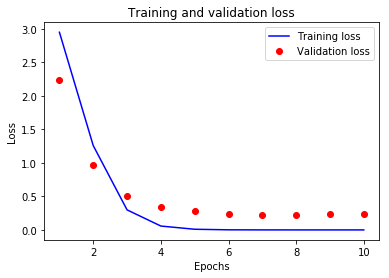

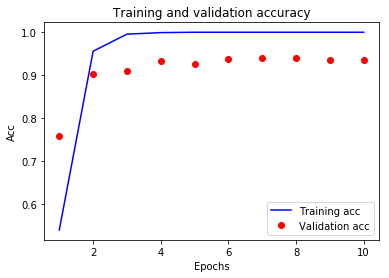

1200/1200 [==============================] - 2s 2ms/step

Results:
Train_acc: 0.949
Val_acc: 0.912
Test_acc: 0.936
F1-score: 0.936


In [242]:
plot_results(history)
evaluation()

Das Overfitting ist immer noch präsent, die Werte sind nun insgesamt besser als beim Modell mit 64 units.

### 12.4.2. Regularisierung der Gewichtungen <a class="anchor" id="12-4-2"/>

Nun wenden wir die <b>Regularisierung</b> auf unser ursprüngliches Modell mit 64 units an. Wir wählen hier den Wert `0.001`. 

In [253]:
from keras import regularizers

model = models.Sequential()
model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation="relu", input_shape=(len(vocab),)))
model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation="relu"))
model.add(layers.Dense(len(np.unique(labels)), activation="softmax"))


model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train,
                   y_train,
                   epochs=10,
                   batch_size=64,
                   validation_data=(X_test, y_test),
                   verbose=1)

Train on 3600 samples, validate on 1200 samples
Epoch 1/10
3600/3600 [==============================] - 25s 7ms/step - loss: 3.3620 - acc: 0.2236 - val_loss: 3.2183 - val_acc: 0.2767
Epoch 2/10
3600/3600 [==============================] - 24s 7ms/step - loss: 2.9996 - acc: 0.4539 - val_loss: 2.8075 - val_acc: 0.5167
Epoch 3/10
3600/3600 [==============================] - 24s 7ms/step - loss: 2.5144 - acc: 0.6650 - val_loss: 2.3402 - val_acc: 0.7083
Epoch 4/10
3600/3600 [==============================] - 24s 7ms/step - loss: 2.0568 - acc: 0.8297 - val_loss: 1.9687 - val_acc: 0.8375
Epoch 5/10
3600/3600 [==============================] - 24s 7ms/step - loss: 1.7222 - acc: 0.9075 - val_loss: 1.7156 - val_acc: 0.8700
Epoch 6/10
3600/3600 [==============================] - 24s 7ms/step - loss: 1.4810 - acc: 0.9358 - val_loss: 1.5423 - val_acc: 0.8800
Epoch 7/10
3600/3600 [==============================] - 25s 7ms/step - loss: 1.3065 - acc: 0.9472 - val_loss: 1.4154 - val_acc: 0.8825
Epoch 8

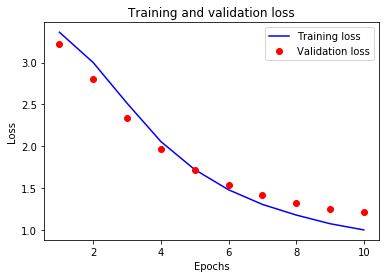

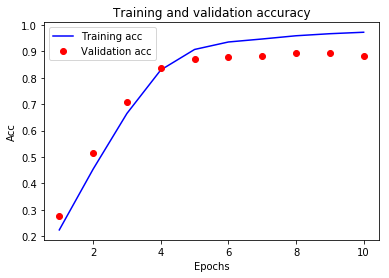

1200/1200 [==============================] - 3s 2ms/step

Results:
Train_acc: 0.786
Val_acc: 0.764
Test_acc: 0.882
F1-score: 0.882


In [254]:
plot_results(history)
evaluation()

Mit der L2-Regularisierung sind die Werte insgesamt schlechter geworden, die Training accuracy und die Validation accuracy nähern sich jedoch an. Wir testen nun den gleichen Wert mit unserem Modell mit 128 units.

In [259]:
model = models.Sequential()
model.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), activation="relu", input_shape=(len(vocab),)))
model.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), activation="relu"))
model.add(layers.Dense(len(np.unique(labels)), activation="softmax"))


model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train,
                   y_train,
                   epochs=10,
                   batch_size=64,
                   validation_data=(X_test, y_test),
                   verbose=1)

Train on 3600 samples, validate on 1200 samples
Epoch 1/10
3600/3600 [==============================] - 36s 10ms/step - loss: 3.3182 - acc: 0.3217 - val_loss: 3.0161 - val_acc: 0.4300
Epoch 2/10
3600/3600 [==============================] - 35s 10ms/step - loss: 2.6337 - acc: 0.6042 - val_loss: 2.3199 - val_acc: 0.7400
Epoch 3/10
3600/3600 [==============================] - 34s 9ms/step - loss: 2.0036 - acc: 0.8433 - val_loss: 1.8557 - val_acc: 0.8467
Epoch 4/10
3600/3600 [==============================] - 34s 9ms/step - loss: 1.5858 - acc: 0.9161 - val_loss: 1.5691 - val_acc: 0.8708
Epoch 5/10
3600/3600 [==============================] - 34s 10ms/step - loss: 1.3361 - acc: 0.9403 - val_loss: 1.4048 - val_acc: 0.8983
Epoch 6/10
3600/3600 [==============================] - 35s 10ms/step - loss: 1.1775 - acc: 0.9561 - val_loss: 1.3040 - val_acc: 0.9042
Epoch 7/10
3600/3600 [==============================] - 38s 10ms/step - loss: 1.0689 - acc: 0.9639 - val_loss: 1.2402 - val_acc: 0.9008
Ep

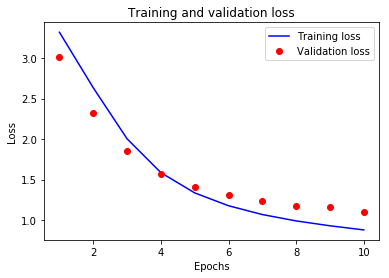

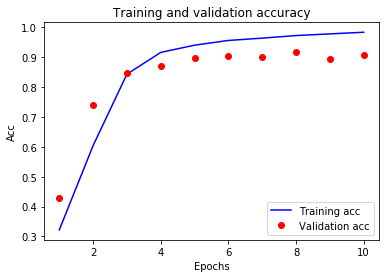

1200/1200 [==============================] - 4s 3ms/step

Results:
Train_acc: 0.848
Val_acc: 0.831
Test_acc: 0.908
F1-score: 0.908


In [260]:
plot_results(history)
evaluation()

Die Werte verbessern sich wieder, während der Unterschied zwischen Trainings und Validation Accuracy sogar geringer geworden ist. 

### 12.4.3. Dropout <a class="anchor" id="12-4-3"/>

Zuletzt implementieren wir Dropout. Dazu benutzen wir das ursprüngliche Modell von 64 units und fügen nach dem Hidden Layer einen Dropout-Layer mit der Dropout-Quote `0.3` hinzu.

In [265]:
from keras.layers import Dropout
model = models.Sequential()
model.add(layers.Dense(64, activation="relu", input_shape=(len(vocab),)))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(len(np.unique(labels)), activation="softmax"))


model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train,
                   y_train,
                   epochs=10,
                   batch_size=64,
                   validation_data=(X_test, y_test),
                   verbose=1)

Train on 3600 samples, validate on 1200 samples
Epoch 1/10
3600/3600 [==============================] - 19s 5ms/step - loss: 3.2101 - acc: 0.3056 - val_loss: 2.9177 - val_acc: 0.6108
Epoch 2/10
3600/3600 [==============================] - 18s 5ms/step - loss: 2.4061 - acc: 0.7044 - val_loss: 2.0740 - val_acc: 0.8283
Epoch 3/10
3600/3600 [==============================] - 18s 5ms/step - loss: 1.4190 - acc: 0.8719 - val_loss: 1.2796 - val_acc: 0.8908
Epoch 4/10
3600/3600 [==============================] - 18s 5ms/step - loss: 0.7297 - acc: 0.9361 - val_loss: 0.8000 - val_acc: 0.9158
Epoch 5/10
3600/3600 [==============================] - 18s 5ms/step - loss: 0.3596 - acc: 0.9700 - val_loss: 0.5533 - val_acc: 0.9183
Epoch 6/10
3600/3600 [==============================] - 18s 5ms/step - loss: 0.1713 - acc: 0.9922 - val_loss: 0.4178 - val_acc: 0.9250
Epoch 7/10
3600/3600 [==============================] - 18s 5ms/step - loss: 0.0802 - acc: 0.9972 - val_loss: 0.3375 - val_acc: 0.9333
Epoch 8

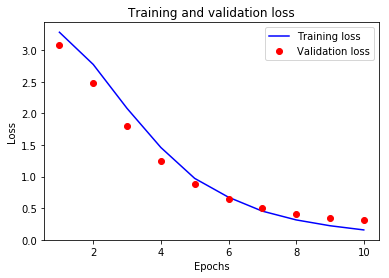

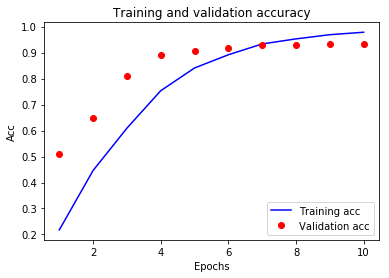

1200/1200 [==============================] - 2s 1ms/step

Results:
Train_acc: 0.759
Val_acc: 0.84
Test_acc: 0.933
F1-score: 0.933


In [263]:
plot_results(history)
evaluation()

Hier kommt es zu <b>Underfitting</b>, unsere Validation-Accuracy ist besser als unsere Trainings-Accuracy. Die Kurve der Trainings accuracy scheint jedoch noch anzusteigen, weshalb wir unser Modell länger trainieren (10 Epochen → 20 Epochen).

In [266]:
model = models.Sequential()
model.add(layers.Dense(64, activation="relu", input_shape=(len(vocab),)))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(len(np.unique(labels)), activation="softmax"))


model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train,
                   y_train,
                   epochs=20,
                   batch_size=64,
                   validation_data=(X_test, y_test),
                   verbose=1)

Train on 3600 samples, validate on 1200 samples
Epoch 1/20
3600/3600 [==============================] - 20s 6ms/step - loss: 3.2632 - acc: 0.3158 - val_loss: 3.0410 - val_acc: 0.6317
Epoch 2/20
3600/3600 [==============================] - 18s 5ms/step - loss: 2.5938 - acc: 0.6697 - val_loss: 2.2644 - val_acc: 0.7825
Epoch 3/20
3600/3600 [==============================] - 18s 5ms/step - loss: 1.6200 - acc: 0.8589 - val_loss: 1.4226 - val_acc: 0.8892
Epoch 4/20
3600/3600 [==============================] - 18s 5ms/step - loss: 0.8390 - acc: 0.9433 - val_loss: 0.8784 - val_acc: 0.9267
Epoch 5/20
3600/3600 [==============================] - 18s 5ms/step - loss: 0.4163 - acc: 0.9711 - val_loss: 0.5871 - val_acc: 0.9308
Epoch 6/20
3600/3600 [==============================] - 19s 5ms/step - loss: 0.1927 - acc: 0.9886 - val_loss: 0.4335 - val_acc: 0.9300
Epoch 7/20
3600/3600 [==============================] - 18s 5ms/step - loss: 0.0937 - acc: 0.9947 - val_loss: 0.3383 - val_acc: 0.9342
Epoch 8

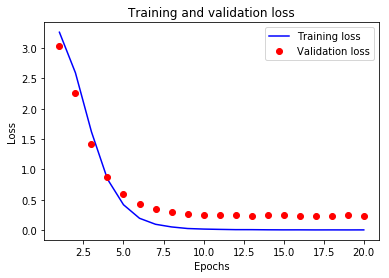

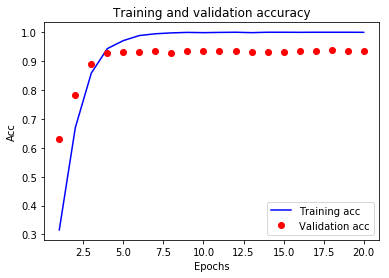

1200/1200 [==============================] - 2s 1ms/step

Results:
Train_acc: 0.937
Val_acc: 0.909
Test_acc: 0.936
F1-score: 0.936


In [267]:
plot_results(history)
evaluation()

Hier erkennen wir wieder unser altes Problem des Overfitting. Durch ein längeres Training konnten die Training Accuracy und die Validatian Accuracy verbessert werden.

### 12.4.4. Early Stopping <a class="anchor" id="12-4-4"/>

Eine weitere wichtige Technik gegen Overfitting, die von Chollet nicht erläutert wird, ist <b>Early Stopping</b>. Dies basiert auf der Erkenntnis, dass sich ein Neuronales Netz nach einer gewissen Zeit wieder verschlecht. Early Stopping versucht, den Trainingsvorgang bei dem Punkt, an dem die Leistungsfähigkeit des Neuronalen Netzes maximal ist, zu stoppen. Early Stopping bei Keras funktioniert hier ähnlich wie bei XGBoost (siehe Kapitel 9.5.3).<br>

In der `fit`-Methode fügen wir unserem Modell ein <b>Callback</b> hinzu. Dem EarlyStopping-Callback übergeben wir drei Parameter. Mit `monitor` wird das Evaluierungsmaß festgelegt, welches die Grundlage für das Early Stopping sein soll. Bei `patience` wird der Wert festgelegt, wie lange das Modell wartet, bis es den Lernprozess abbricht, weil sich die Werte nicht mehr verbessert haben. Dies funktioniert wie bei Early Stopping bei XGBoost (siehe Kapitel 9.5.3). Mit `restore_best_weights = True` legen wir fest, dass das Modell die Epoche mit den besten Werten zurückgibt und nicht die letzte Epoche vor dem Abbruch.<br>

Um einen Effekt bei unserem Modell sehen zu können, erhöhen wir die Epochenanzahl auf 30.

In [7]:
from keras.callbacks import EarlyStopping

model = models.Sequential()
model.add(layers.Dense(64, activation="relu", input_shape=(len(vocab),)))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(len(np.unique(labels)), activation="softmax"))


model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train,
                   y_train,
                   epochs=30,
                   batch_size=64,
                   validation_data=(X_test, y_test),
                   verbose=1,
                   callbacks = [EarlyStopping(monitor='val_loss', 
                                               patience=2,
                                               restore_best_weights=True)])

Train on 3600 samples, validate on 1200 samples
Epoch 1/30
3600/3600 [==============================] - 19s 5ms/step - loss: 3.1681 - acc: 0.5358 - val_loss: 2.8154 - val_acc: 0.7425
Epoch 2/30
3600/3600 [==============================] - 10s 3ms/step - loss: 2.1475 - acc: 0.8936 - val_loss: 1.8176 - val_acc: 0.8333
Epoch 3/30
3600/3600 [==============================] - 10s 3ms/step - loss: 1.0043 - acc: 0.9822 - val_loss: 1.0325 - val_acc: 0.9075
Epoch 4/30
3600/3600 [==============================] - 10s 3ms/step - loss: 0.3603 - acc: 0.9972 - val_loss: 0.6333 - val_acc: 0.9200
Epoch 5/30
3600/3600 [==============================] - 10s 3ms/step - loss: 0.1150 - acc: 0.9994 - val_loss: 0.4418 - val_acc: 0.9283
Epoch 6/30
3600/3600 [==============================] - 10s 3ms/step - loss: 0.0344 - acc: 0.9997 - val_loss: 0.3538 - val_acc: 0.9308
Epoch 7/30
3600/3600 [==============================] - 10s 3ms/step - loss: 0.0095 - acc: 1.0000 - val_loss: 0.2995 - val_acc: 0.9325
Epoch 8

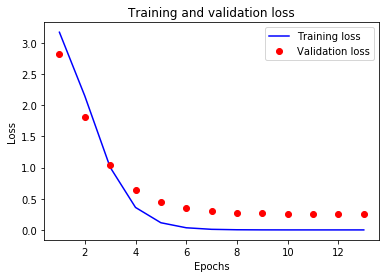

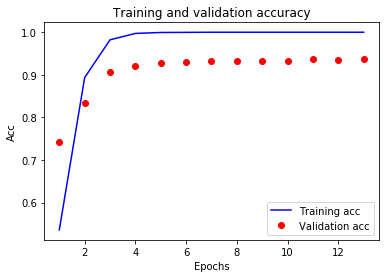

1200/1200 [==============================] - 2s 2ms/step

Results:
Train_acc: 0.954
Val_acc: 0.908
Test_acc: 0.932
F1-score: 0.932


In [10]:
plot_results(history)
evaluation()

EarlyStopping bricht das Training bei Epoche 13 ab. Leider haben wir immer noch Overfitting.

### 12.4.5. Kombination aller Overfitting-Methoden <a class="anchor" id="12-4-5"/>

#### Daten vorbereiten und Implementierung der Methoden `plot_results` und `evaluation`

In [2]:
from keras import models
from keras import layers
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers import Dropout

from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

corpus = pd.read_csv("tutorialdata/corpora/wikicorpus_v2.csv")

vectorizer = TfidfVectorizer()
vector = vectorizer.fit_transform(corpus["text"])
labels = LabelEncoder().fit_transform(corpus["category"])
vocab = vectorizer.vocabulary_




X_train, X_test, y_train, y_test = train_test_split(vector, 
                                                    labels, 
                                                    test_size=0.4, 
                                                    train_size=0.6,
                                                    random_state=42)
X_val = X_test[:1200]
X_test = X_test[1200:]

y_val = y_test[:1200]
y_test = y_test[1200:]

y_val = to_categorical(y_val)
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)

def plot_results(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "ro", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

    plt.clf() #clears the figure

    acc = history.history["acc"]
    val_acc = history.history["val_acc"]

    plt.plot(epochs, acc, "b", label="Training acc")
    plt.plot(epochs, val_acc, "ro", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Acc")
    plt.legend()

    plt.show()
    
    
def evaluation():
    y_pred = model.predict(X_test)
    f1_keras = f1_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average="micro")
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"\nResults:")
    print(f"Train_acc: {np.around(np.mean(history.history['acc']), decimals=3)}")
    print(f"Val_acc: {np.around(np.mean(history.history['val_acc']), decimals=3)}")
    print(f"Test_acc: {np.around(test_acc, decimals=3)}") 
    print(f"F1-score: {str(np.around(f1_keras, decimals=3))}")

Using TensorFlow backend.


#### Das finale Modell

Overfitting ist das größte Problem beim Trainieren von Neuronalen Netzen. Wir hatten hier nur wenige Versuche gestartet, das Overfitting zu umgehen. Für weitere Techniken und Methodiken gegen Overfitting siehe den <a href="https://machinelearningmastery.com/introduction-to-regularization-to-reduce-overfitting-and-improve-generalization-error/">Blog-Eintrag</a> von Jason Brownlee. In der Praxis ist die Suche nach den richtigen Techniken zur Reduzierung des Overfittings ein langwieriger Prozess. Die Handhabung dieses Prozess kann nicht wirklich gesteuert werden, d.h. man kann nicht vor dem Training genau vorhersagen, welche Techniken funktionieren und welche nicht. Dies ist einer der Gründe, warum Deep Learning und das Trainieren der Modelle mehr als Kunst denn als Wissenschaft angesehen wird. Im Folgenden habe ich einmal alle Overfitting-Methoden aus den vorherigen Abschnitten kombiniert und ein stabiles Modell erhalten, welches nicht overfittet.

In [3]:
# für GPU-Probleme, siehe Abschnitt 12.6. "Mögliche Fehler"
from keras import backend as K
if K.backend() == 'tensorflow':
    K.clear_session()

In [7]:
model = models.Sequential()
model.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), activation="relu", input_shape=(len(vocab),)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, kernel_regularizer=regularizers.l2(0.001), activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(len(np.unique(labels)), activation="softmax"))

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train,
                   y_train,
                   epochs=100,
                   batch_size=64,
                   validation_data=(X_test, y_test),
                   verbose=1,
                   callbacks = [EarlyStopping(monitor='val_loss', 
                                               patience=3,
                                               restore_best_weights=True)])

Train on 3600 samples, validate on 1200 samples
Epoch 1/100
3600/3600 [==============================] - 14s 4ms/step - loss: 3.4913 - acc: 0.1144 - val_loss: 3.3617 - val_acc: 0.1867
Epoch 2/100
3600/3600 [==============================] - 13s 4ms/step - loss: 3.1064 - acc: 0.2564 - val_loss: 2.7164 - val_acc: 0.5292
Epoch 3/100
3600/3600 [==============================] - 13s 4ms/step - loss: 2.4538 - acc: 0.4806 - val_loss: 2.0777 - val_acc: 0.7917
Epoch 4/100
3600/3600 [==============================] - 13s 4ms/step - loss: 1.9590 - acc: 0.6664 - val_loss: 1.7829 - val_acc: 0.8625
Epoch 5/100
3600/3600 [==============================] - 13s 4ms/step - loss: 1.7211 - acc: 0.7550 - val_loss: 1.6017 - val_acc: 0.8717
Epoch 6/100
3600/3600 [==============================] - 13s 4ms/step - loss: 1.5555 - acc: 0.8106 - val_loss: 1.4914 - val_acc: 0.8892
Epoch 7/100
3600/3600 [==============================] - 13s 4ms/step - loss: 1.4427 - acc: 0.8494 - val_loss: 1.4312 - val_acc: 0.8967


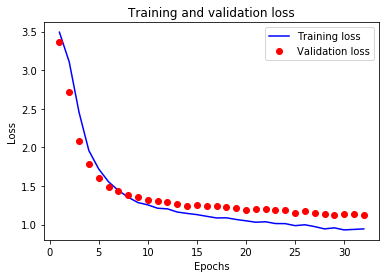

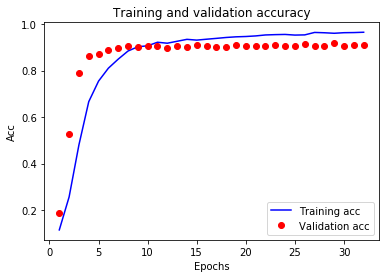

1200/1200 [==============================] - 2s 2ms/step

Results:
Train_acc: 0.858
Val_acc: 0.866
Test_acc: 0.918
F1-score: 0.918


In [9]:
plot_results(history)
evaluation()

## 12.5. Hyperparameteroptimierung mit hyperas <a class="anchor" id="12-5"/>

In diesem Kapitel schauen wir uns die Hyperparameteroptimierung bei Keras an. Dafür verwenden wir den Wrapper <a href="https://github.com/maxpumperla/hyperas">hyperas</a>.<br>

<b>Hinweis vorweg</b>: Der hier dargestellte Code wurde nicht vollends ausgeführt. Ein großes Problem beim Trainieren von Neuronalen Netzen ist der OOM-Fehler (= <i>out-of-memory</i>), bei dem die GPU oder CPU, je nachdem vorauf man trainiert, keinen Speicher mehr zur Verfügung stellen kann. Wie anfangs bereits erwähnt, kann man anstatt der lokalen GPU auch die GPU von <b>Google Colab</b> verwenden. Die letzte Lösung ist bei mir aufgrund von einer langsamen Internet-Verbindung nur bedingt möglich gewesen. Ich konnt das OOM-Problem bei meiner lokalen GPU innerhalb des Notebooks nicht beheben, welches ich mir nicht ganz erklären kann, vor allem da es zu Beginn funktioniert hatte. Dies mag an lokalen Problemen mit CUDA oder ähnlichem liegen oder auch an Juypter Notebook. Trotzdem werde ich im Folgenden zeigen, wie hyperas genutzt werden kann und zeige auch einige Techniken, um das OOM-Problem (theoretisch) lösen zu können. Teile des zu erwartenden Outputs habe ich aus dem Output eines Shell-Skripts kopiert, dazu gleich mehr. Am Ende des Abschnittes zeige ich eine Zusammenfassung verschiedener möglicher Lösungen für das OOM-Problem.

In [1]:
from keras import models
from keras import layers
from keras.optimizers import Adam, RMSprop, SGD
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers import Dropout
from keras.layers.core import Dense, Dropout, Activation
from keras import backend as K

from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

from hyperas.distributions import uniform
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


Für die Hyperparameteroptimierung mit hyperas orientieren wir uns am Beispiel der <a href="https://github.com/maxpumperla/hyperas">Github-Seite</a>, indem wir das Laden des Korpus, das Encoding der Kategorien, die Vektorisierung der Artikel und die Aufteilung in Training-, Validierungs- und Testdatensätze in einer Funktion `data` speichern.

In [2]:
def data():
    
    corpus = pd.read_csv("tutorialdata/corpora/wikicorpus_v2.csv")

    vectorizer = TfidfVectorizer()
    vector = vectorizer.fit_transform(corpus["text"])
    labels = LabelEncoder().fit_transform(corpus["category"])
    vocab = vectorizer.vocabulary_

    X_train, X_test, y_train, y_test = train_test_split(vector, 
                                                            labels, 
                                                            test_size=0.4, 
                                                            train_size=0.6,
                                                            random_state=42)
    X_val = X_test[:1200]
    X_test = X_test[1200:]

    y_val = y_test[:1200]
    y_test = y_test[1200:]

    y_val = to_categorical(y_val)
    y_test = to_categorical(y_test)
    y_train = to_categorical(y_train)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Nun definieren wir eine Funktion `create_model()`, in der unser Neuronales Netz erstellt wird. Der Aufbau dieses Netzes unterscheidet sich vom Aufbau, den wir im letzten Kapitel gesehen hatten. Die Aktivierungsfunktion definieren wir hier in einer eigenen Zeile, um den Code übersichtlicher zu gestalten. 

Die Werte der verschiedenen Parameter, die wir optimieren wollen, werden hier in einer Liste gespeichert, die `{{choice()}}` übergeben wird. Hier wählen wir zunächst nur die Dense Layer und ihre Units-Größe sowie die Dropout-Layer und ihre Dropout-Quoten. Für den ersten Test verwenden wir eine Epochenzahl von 10.<br>

<b>Hinweis</b>: 

Ich habe das Dictionary, welches zurückgegeben werden soll, im Vergleich zum Codebeispiel der hyperas-Githubseite verändert, indem ich den `model`-key entfernt habe:<br>
```
     {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}
→    {'loss': -validation_acc, 'status': STATUS_OK}
```

Laut <a href="https://github.com/maxpumperla/hyperas/issues/16">Angaben</a> des hyperas-Entwickler kann dies beim OOM-Problem helfen. Ein weitere Maßnahme gegen das OOM-Problem ist die reduzierte Batchsize auf 16, anstatt wie im vorherigen Abschnitt auf 64. 

In [3]:
def create_model(X_train, y_train, X_val, y_val, X_test, y_test, vocab, labels):
    
    model = models.Sequential()
    model.add(Dense({{choice([16, 32, 64])}}, input_shape=(len(vocab),)))
    model.add(Activation('relu'))
    model.add(Dropout({{choice([0.2, 0.3])}}))
    model.add(Dense({{choice([16, 32, 64])}}))
    model.add(Activation('relu'))
    model.add(Dropout({{choice([0.2, 0.3])}})) 
    model.add(Dense(len(np.unique(labels))))
    model.add(Activation('softmax'))

    model.compile(optimizer='rmsprop',
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    
    history = model.fit(X_train,
                        y_train,
                        epochs=10,
                        batch_size=16,
                        validation_data=(X_val, y_val),
                        verbose=2)
              
    score = model.evaluate(X_test, y_test, verbose=0)
    validation_acc = np.mean(history.history['val_acc']) 
    if K.backend() == 'tensorflow':
        K.clear_session()
    return {'loss': -validation_acc, 'status': STATUS_OK}

Nun rufen wir die eigentliche Optimierungsfunktion ein. Dieser übergeben wir unsere Funktion `create_model`, unser Funktion `data`, die Optimierunfsfunktion <b>Tree Parzen Estimator</b> (kurz: TPE), die maximale Anzahl der der Optimierungsdurchgänge mit `max_eval`, die Funktion `Trials` und der Name des Notebooks. Letzteres ist sehr wichtig, wenn man mit einem Jupyter Notebook arbeitet.<br>

<b>Hinweis</b>:<br>
Es ist nicht unbedingt empfehlenswert, den Optimierungs-Code in Jupyter Notebooks auszuführen, da der Fehler `The kernel appears to have died. It will restart automatically.`[<sup>1</sup>](#fn1) relativ oft erscheinen wird. Zu diesem Zweck habe ich im `tutorialdata`-Ordner ein Python-Skript `optimization_nn.py` gespeichert, welches über die Shell aufgerufen werden kann. Vor der Ausführung sollten jedoch die Parameter im Skript nach Belieben angepasst werden.

<hr style="border: 0.1px solid black;"/>
<span id="fn1" style="font-size:8pt; line-height:1"><sup style="font-size:5pt">1</sup> &nbsp; Sollte dies geschehen, müssen alle Code-Zellen ab Beginn des Abschnittes neu ausgeführt werden.</span>

In [ ]:
%%time
best_run, best_model = optim.minimize(model=create_model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=5,
                                      trials=Trials(),
                                      notebook_name='Kapitel 12 - Neuronale Netze mit Keras')

>>> Imports:
#coding=utf-8

try:
    from keras import backend as K
except:
    pass

try:
    from keras import models
except:
    pass

try:
    from keras import layers
except:
    pass

try:
    from keras.utils.np_utils import to_categorical
except:
    pass

try:
    from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
except:
    pass

try:
    from sklearn.preprocessing import LabelEncoder, OneHotEncoder
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    from sklearn.metrics import f1_score
except:
    pass

try:
    from keras import regularizers
except:
    pass

try:
    from keras.layers import Dropout
except:
    pass

try:
    from keras.callbacks import EarlyStopping
except:
    pass

try:
    from keras import models
except:
    pass

try:
  

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = data()
print("Evalutation of best performing model:" )
print(best_model.evaluate(X_test, y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)

Eine mögliche Ausgabe von `best_run` und `best_model`:<br>

`best_run` → `[0.22213956201202656, 0.9351851848698167]`<br>
`best_model` → `{'Dense': 2, 'Dense_1': 2, 'Dropout': 0, 'Dropout_1': 1}`
<br>

Die Dense- und Dropout-Layer von `best_model` werden nummeriert. Die Layer ohne Nummerierung sind die Input-Layer oder der erste Dropout-Layer. Die Zahlen geben die Position der Parameter in der Parameterliste an. So gibt hyperas hier an, dass wir als Units für die Dense-Layer 32 wählen sollen, für den ersten Dropout-Layer 0.2 und für den zweiten Dropout-Layer 0.3.<br>

Für die Dropout-Layer können wir anstatt `{{choice()}}` auch `{{uniform(0,1}}` wählen. Dabei werden zufällig Werte zwischen 0 und 1 ausgewählt.<br>
```
    model.add(Dense({{choice([16, 32, 64])}}, input_shape=(len(vocab),)))
    model.add(Activation('relu'))
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(Dense({{choice([16, 32, 64])}}))
    model.add(Activation('relu'))
    model.add(Dropout({{uniform(0, 1)}}))
```

In der folgenden `create_model()`-Funktion werden weitere Optimierungsmöglichkeiten gezeigt. So ist es mithilfe von `if` möglich, Hidden Layer zufällig auswählen zu lassen (siehe # 1 #). Zudem kann man mit `if` zufällig vordefinierte Variablen auswählen lassen wie in diesem Fall die Wahl des Optimizers (siehe # 2 #). Dies kann nützlich sein, wenn wie hier bei den Optimizern die möglichen Parameter selbst wieder Parameter zur Verfügung stellen.

In [ ]:
def create_model(X_train, y_train, X_val, y_val, X_test, y_test, vocab, labels):
    
    model = models.Sequential()
    model.add(Dense({{choice([16, 32, 64])}}, input_shape=(len(vocab),)))
    model.add(Activation('relu'))
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(Dense({{choice([16, 32, 64])}}))
    model.add(Activation('relu'))
    model.add(Dropout({{uniform(0, 1)}}))
           
    # 1 #
    if {{choice(['three', 'four'])}} == 'four':
        model.add(Dense({{choice([16, 32, 64])}}))
        model.add(Dropout({{uniform(0, 1)}}))
        model.add(Activation('relu'))          
              
    model.add(Dense(len(np.unique(labels))))
    model.add(Activation('softmax'))
    
    # 2 #
    adam = Adam(lr={{choice([10**-3, 10**-2, 10**-1])}})
    rmsprop = RMSprop(lr={{choice([10**-3, 10**-2, 10**-1])}})
    sgd = SGD(lr={{choice([10**-3, 10**-2, 10**-1])}})
   
    choiceval = {{choice(['adam', 'sgd', 'rmsprop'])}}
    
    # 2 #
    if choiceval == 'adam':
        optim = adam
    elif choiceval == 'rmsprop':
        optim = rmsprop
    else:
        optim = sgd
    

    model.compile(optimizer=optim,
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    
    history = model.fit(X_train,
                        y_train,
                        epochs=10,
                        batch_size=16,
                        validation_data=(X_val, y_val),
                        verbose=2)
              
    score = model.evaluate(X_test, y_test, verbose=0)
    validation_acc = np.mean(history.history['val_acc']) 
    if K.backend() == 'tensorflow':
        K.clear_session()
    return {'loss': -validation_acc, 'status': STATUS_OK}

#### Fazit zu hyperas

<b>Hyperas</b> ist ein simples und nützliches Tool zur Hyperoptimierung in Keras. Leider ist die Optimierung aufgrund des OOM-Problems nicht immer ganz frustfrei. Die eigentliche Benutzung ist jedoch sehr simpel und intuitiv. Bei einer wirklichen Optimierung sollte anders als in den Beispielen `max_evals` höher als 5 gesetzt werden.

#### Liste der möglichen Lösungen gegen das OOM-Problem

- Ausführung im Notebook (<b>nicht empfohlen</b>)
    - `'model': model` aus der Funktion `create_model()` entfernen
    - batchsize reduzieren
    - Neustart des Notebookservers
    - folgenden Code hinzufügen, um das vorherige Modell zu löschen und Speicher freizugeben:
    
    ``` 
    if K.backend() == 'tensorflow':
        K.clear_session()
    ```
- Ausführung als Python-Skript (<b>empfohlen</b>)
    - Alle Kommentare entfernen (siehe <a href="https://stackoverflow.com/questions/43533610/how-to-use-hyperopt-for-hyperparameter-optimization-of-keras-deep-learning-netwo">StackOverflow-Antwort</a>)
    - `'model': model` wieder hinzufügen → hat bei mir in Verbindung mit den entfernten Kommentaren funktioniert
    - Batchsize reduzieren
    - folgenden Code hinzufügen, um das vorherige Modell zu löschen und Speicher freizugeben:
    
    ``` 
    if K.backend() == 'tensorflow':
        K.clear_session()
    ```

## 12.6. Mögliche Fehler <a class="anchor" id="12-6"/>

- "OOM when allocating tensor..." → GPU ist <i>out of memory</i> (= OOM). Folgendes kann dabei helfen:
    - Reduzierung der batch size
    - Neustart des Notebookservers
    - Ausführung als Python-Skript (siehe Abschnitt 12.5)
    - 'model': model aus der Funktion create_model() entfernen
    - Ausführen der folgenden Code-Zeile vor jedem Trainingsdurchlauf
    
    ```
    from keras import backend as K
    
    if K.backend() == 'tensorflow':
        K.clear_session()
    ```
- "Error when checking target: expected dense_7 to have shape (30,) but got array with shape (1,)" oder ähnlicher Fehler mit anderen Werten → Die encodeten Label wurden nicht in eine One-Hot-Codierung überführt und haben die falsche Dimension. Der folgende Teil fehlt oder wurde nicht ausgeführt:

    ```
    y_val = to_categorical(y_val)
    y_test = to_categorical(y_test)
    y_train = to_categorical(y_train)
    ```